In [48]:
import os
import zipfile
import tensorflow as tf
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
local_zip = 'rice_image.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('D:/Semester 5/Python/Image Classification Model Deployment/rice_image')
zip_ref.close()

In [22]:
os.listdir('rice_image')

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [23]:
print('total Arborio images :', len(os.listdir('rice_image/Arborio')))
print('total Basmati images :', len(os.listdir('rice_image/Basmati')))
print('total Ipsala images :', len(os.listdir('rice_image/Ipsala')))
print('total Jasmine images :', len(os.listdir('rice_image/Jasmine')))
print('total Karacadag images :', len(os.listdir('rice_image/Karacadag')))

total Arborio images : 2500
total Basmati images : 2500
total Ipsala images : 2500
total Jasmine images : 2500
total Karacadag images : 2500


In [24]:
train_dir = os.path.join('rice_image')

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']  
train_data = []
for class_name in classes:
    class_path = os.path.join('rice_image', class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        train_data.append((img_path, class_name))

In [46]:
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [49]:
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame(train_data, columns=['filename', 'class']),
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame(validation_data, columns=['filename', 'class']),
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 10000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [28]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  
])

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)


In [36]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9673
Epoch 1: val_accuracy improved from -inf to 0.84880, saving model to best_model.h5
391/391 [==============================] - 604s 2s/step - loss: 0.0940 - accuracy: 0.9673 - val_loss: 0.5195 - val_accuracy: 0.8488
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9799
Epoch 2: val_accuracy improved from 0.84880 to 0.88872, saving model to best_model.h5
391/391 [==============================] - 804s 2s/step - loss: 0.0616 - accuracy: 0.9799 - val_loss: 0.3774 - val_accuracy: 0.8887
Epoch 3/20
391/391 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9787
Epoch 3: val_accuracy improved from 0.88872 to 0.97152, saving model to best_model.h5
391/391 [==============================] - 1012s 3s/step - loss: 0.0669 - accuracy: 0.9787 - val_loss: 0.0864 - val_accuracy: 0.9715
Epoch 4/20
391/391 [==============================] - ETA: 0

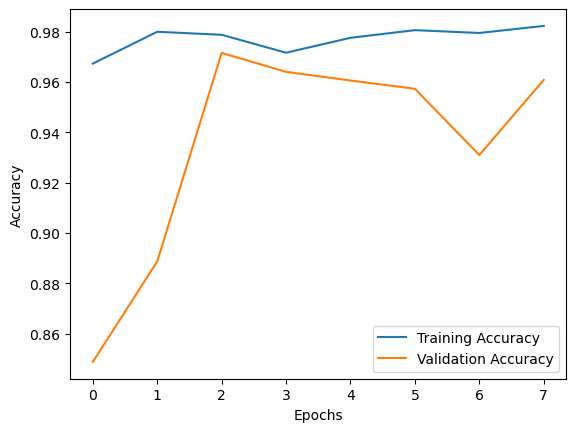

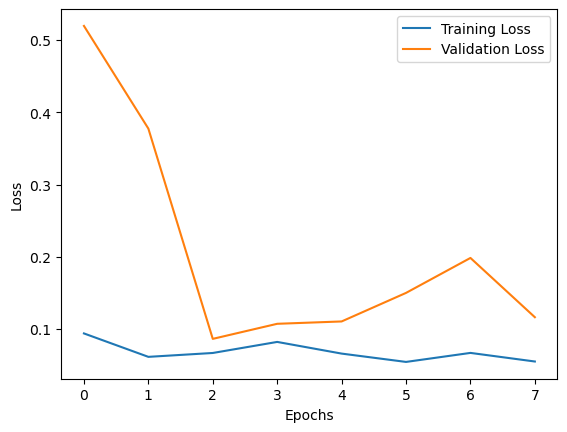

In [38]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
model.save('final_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

c:\Users\A S U S\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\ASUS~1\AppData\Local\Temp\tmpiux0wwat\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS~1\AppData\Local\Temp\tmpiux0wwat\assets
